In [1]:
import re
import time

import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedShuffleSplit
from keras.models import Model
from keras.models import load_model
from keras.layers import Input, Dense, GRU, concatenate
from keras import metrics
from keras import backend as K
from keras.utils import plot_model
from keras.callbacks import EarlyStopping, ModelCheckpoint

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

# Custom library for the project
import sys
sys.path.insert(0, '../../../src')
import harmoutil

%matplotlib inline

Using TensorFlow backend.


In [2]:
# Load data
raw_data = harmoutil.load_pickled_data("../../../data/refined_data.pkl") # lists of (chord label, melody seqs) by sections
augmented_data = harmoutil.transpose_and_augment_data(raw_data)
data = [harmoutil.to_sevenths(section) for section in augmented_data]
data = [harmoutil.melody_to_octave_range(section) for section in data]

In [3]:
# Isolate meaningful data
def get_notes_by_chord(beats):
    return [note for beat in beats for note in beat]

def get_chords_by_section(section):
    return [chord_info[0] for chord_info in section]

chords_by_sections = [get_chords_by_section(section) for section in data]
chords = [chord_info[0] for section in data for chord_info in section]
unique_chords = sorted(list(set(chords)))

notes_by_chords = [get_notes_by_chord(chord_info[1]) for section in data for chord_info in section]
notes = [note for chord_notes in notes_by_chords for note in chord_notes]
unique_notes = sorted(list(set(notes)))

print("Unique notes ({}): {}".format(len(unique_notes), unique_notes))
print("Unique chords ({}): {}".format(len(unique_chords), unique_chords))

Unique notes (13): [-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
Unique chords (193): ['A', 'A+', 'A+7', 'A+j7', 'A-', 'A-6', 'A-7', 'A-j7', 'A6', 'A7', 'Ab', 'Ab+', 'Ab+7', 'Ab+j7', 'Ab-', 'Ab-6', 'Ab-7', 'Ab-j7', 'Ab6', 'Ab7', 'Abj7', 'Abm7b5', 'Abo', 'Abo7', 'Absus', 'Absus7', 'Aj7', 'Am7b5', 'Ao', 'Ao7', 'Asus', 'Asus7', 'B', 'B+', 'B+7', 'B+j7', 'B-', 'B-6', 'B-7', 'B-j7', 'B6', 'B7', 'Bb', 'Bb+', 'Bb+7', 'Bb+j7', 'Bb-', 'Bb-6', 'Bb-7', 'Bb-j7', 'Bb6', 'Bb7', 'Bbj7', 'Bbm7b5', 'Bbo', 'Bbo7', 'Bbsus', 'Bbsus7', 'Bj7', 'Bm7b5', 'Bo', 'Bo7', 'Bsus', 'Bsus7', 'C', 'C+', 'C+7', 'C+j7', 'C-', 'C-6', 'C-7', 'C-j7', 'C6', 'C7', 'Cj7', 'Cm7b5', 'Co', 'Co7', 'Csus', 'Csus7', 'D', 'D+', 'D+7', 'D+j7', 'D-', 'D-6', 'D-7', 'D-j7', 'D6', 'D7', 'Db', 'Db+', 'Db+7', 'Db+j7', 'Db-', 'Db-6', 'Db-7', 'Db-j7', 'Db6', 'Db7', 'Dbj7', 'Dbm7b5', 'Dbo', 'Dbo7', 'Dbsus', 'Dbsus7', 'Dj7', 'Dm7b5', 'Do', 'Do7', 'Dsus', 'Dsus7', 'E', 'E+', 'E+7', 'E+j7', 'E-', 'E-6', 'E-7', 'E-j7', 'E6', 'E7', 'Eb', 'Eb+', 'Eb+7

In [4]:
# Create categorical data mappings
note_to_int = dict([(c, i) for i, c in enumerate(unique_notes[1:])])
note_to_int[-1] = len(note_to_int)
note_to_int['<pad>'] = len(note_to_int)

int_to_note = dict([(k, v) for v, k in note_to_int.items()])

chord_to_int = dict([(c, i) for i, c in enumerate(unique_chords)])
chord_to_int['<bos>'] = len(chord_to_int)

int_to_chord = dict([(k, v) for v, k in chord_to_int.items()])

print("Melody note to integer mapping:\n {}\n".format(note_to_int))
print("Integer to melody note mapping:\n {}\n".format(int_to_note))
print("Chord label to integer mapping:\n {}\n".format(chord_to_int))
print("Integer to chord label mapping:\n {}\n".format(int_to_chord))

Melody note to integer mapping:
 {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10, 11: 11, '<pad>': 13, -1: 12}

Integer to melody note mapping:
 {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10, 11: 11, 12: -1, 13: '<pad>'}

Chord label to integer mapping:
 {'Eb': 122, 'Fo': 156, 'E+j7': 115, 'Absus7': 25, 'Ao7': 29, 'A6': 8, 'Bb6': 50, 'Gb+7': 172, 'F+j7': 147, 'Ao': 28, 'Bb+7': 44, 'Cj7': 74, 'D-6': 85, 'Gj7': 186, 'Gbo': 182, 'D': 80, 'Dsus': 110, 'D-': 84, 'C': 64, 'G6': 168, 'Esus': 142, 'B-': 36, 'B-7': 38, 'Gbm7b5': 181, 'Dbsus7': 105, 'F-7': 150, 'Bsus7': 63, 'Fo7': 157, 'Go': 188, 'Ab-6': 15, 'D+j7': 83, 'A-7': 6, 'C+7': 66, 'Dbm7b5': 101, 'Gbj7': 180, 'Bbsus': 56, 'Ebsus7': 137, 'Aj7': 26, 'Db7': 99, 'C6': 72, 'Fsus7': 159, 'G7': 169, 'Db-': 94, 'Bm7b5': 59, 'Ebj7': 132, 'Abj7': 20, 'Db': 90, 'Bb7': 51, 'C-': 68, 'Db+': 91, 'Dbsus': 104, 'G-': 164, 'Gb6': 178, 'B7': 41, 'Abo': 22, 'Dj7': 106, 'Db-6': 95, 'F': 144, 'Fj7': 154, 'Eo': 140, 

In [5]:
# Refine data that will actually be used
def check_if_augmented_major(section):
    section_chords = get_chords_by_section(section)
    for ch in section_chords:
        if "+j7" in ch:
            return True
    return False

def check_if_NC(section):
    section_chords = get_chords_by_section(section)
    for ch in section_chords:
        if "NC" in ch:
            return True
    return False

# Remove sections that involve augmented major chords (since not enough data to even allow StratifiedShuffleSplit)
section_data = [section for section in data if not check_if_augmented_major(section)]
print("Number of sections: {}\n".format(len(section_data)))

section_data = [section for section in section_data if not check_if_NC(section)]
print("Number of sections: {}\n".format(len(section_data)))

chords_by_sections = [get_chords_by_section(section) for section in section_data]
chords_data = [chord_info[0] for section in section_data for chord_info in section]
notes_by_chords = [get_notes_by_chord(chord_info[1]) for section in section_data for chord_info in section]

Number of sections: 28836

Number of sections: 28416



In [6]:
# Define numerical variables

n_samples = len(chords_data)
n_chords = len(chord_to_int)
n_notes = len(note_to_int)
n_pitches = 12
max_mel_len = max([len(mel) for mel in notes_by_chords])
chord_context_len = 7

# print("Total number of samples: {}".format(n_samples))
print("Total number of samples: {}".format(n_samples))
print("Number of distinct melody notes: {}".format(n_notes))
print("Number of distinct chord labels: {}".format(n_chords))
print("Number of pitches: {}".format(n_pitches))
print("Maximum length of melody sequences for one chord: {}".format(max_mel_len))
print("Number of past chords given as input: {}".format(chord_context_len))

Total number of samples: 327708
Number of distinct melody notes: 14
Number of distinct chord labels: 194
Number of pitches: 12
Maximum length of melody sequences for one chord: 115
Number of past chords given as input: 7


In [7]:
# Prepare tensor data
def pad_melody(melody, max_len):
    return melody + (max_len-len(melody))*['<pad>']

def build_input_chord_sequences(chord_seq, context_len):
    padded_sequence = context_len*['<bos>'] + chord_seq
    formatted_sequences = [padded_sequence[i:i+context_len+1] for i in range(len(chord_seq))]
    return formatted_sequences

# Melody
input_melody_data = [pad_melody(melody, max_mel_len) for melody in notes_by_chords]
print("Sample input melody sequence: {}\n".format(input_melody_data[5]))

# Chords
formatted_chords_data = []
for section_chords in chords_by_sections:
    formatted_chords_data += build_input_chord_sequences(section_chords, chord_context_len)
    
input_chords_data = [ch[:-1] for ch in formatted_chords_data]
target_chords_data = [ch[-1] for ch in formatted_chords_data]
print("Sample input chord sequence: {}\n".format(input_chords_data[5]))
print("Sample target chord: {}\n".format(target_chords_data[5]))

print("Input melody: {}, Input chords: {}, Target chords: {}".format(len(input_melody_data), len(input_chords_data), len(target_chords_data)))

Sample input melody sequence: [8, 3, 6, '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>

In [8]:
# Build tensors

X_melody = np.zeros((n_samples, max_mel_len, n_notes), dtype='float32')
X_labels = np.zeros((n_samples, chord_context_len, n_chords), dtype='float32')
X_pitches = np.zeros((n_samples, chord_context_len, n_pitches), dtype='float32')
Y_labels = np.zeros((n_samples, n_chords), dtype='float32')
Y_pitches = np.zeros((n_samples, n_pitches), dtype='float32')

for i, (input_mel, input_ch, target_ch) in enumerate(zip(input_melody_data, input_chords_data, target_chords_data)):
    Y_labels[i, chord_to_int[target_ch]] = 1
    if not target_ch == "<bos>":
        for k, pitch_presence in enumerate(harmoutil.chord_to_notes(target_ch)):
            Y_pitches[i, k] = pitch_presence
            
    for j, chord in enumerate(input_ch):
        X_labels[i, j, chord_to_int[chord]] = 1
        if not chord == "<bos>":
            for k, pitch_presence in enumerate(harmoutil.chord_to_notes(chord)):
                X_pitches[i, j, k] = pitch_presence
            
    for j, note in enumerate(input_mel):
        X_melody[i, j, note_to_int[note]] = 1


In [9]:
# Split dataset into 80%-10%-10% train-valid-test

seed = 0

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=seed)

for train_index, aux_index in sss.split(X_labels, Y_labels):
    X_melody_train, X_melody_aux = X_melody[train_index], X_melody[aux_index]
    
    X_labels_train, X_labels_aux = X_labels[train_index], X_labels[aux_index]
    X_pitches_train, X_pitches_aux = X_pitches[train_index], X_pitches[aux_index]
    
    Y_labels_train, Y_labels_aux = Y_labels[train_index], Y_labels[aux_index]
    Y_pitches_train, Y_pitches_aux = Y_pitches[train_index], Y_pitches[aux_index]
    
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=seed)

for valid_index, test_index in sss.split(X_labels_aux, Y_labels_aux):
    X_melody_valid, X_melody_test = X_melody_aux[valid_index], X_melody_aux[test_index]
    
    X_labels_valid, X_labels_test = X_labels_aux[valid_index], X_labels_aux[test_index]
    X_pitches_valid, X_pitches_test = X_pitches_aux[valid_index], X_pitches_aux[test_index]
    
    Y_labels_valid, Y_labels_test = Y_labels_aux[valid_index], Y_labels_aux[test_index]
    Y_pitches_valid, Y_pitches_test = Y_pitches_aux[valid_index], Y_pitches_aux[test_index]

In [10]:
# Define neural net architecture

latent_dim = 128

melody_input = Input(shape=(max_mel_len, n_notes))
melody_gru1 = GRU(latent_dim, return_sequences=True)(melody_input)
melody_gru2 = GRU(latent_dim, return_sequences=True)(melody_gru1)
melody_gru3 = GRU(latent_dim)(melody_gru2)

pitch_input = Input(shape=(chord_context_len, n_pitches))
pitch_gru1 = GRU(latent_dim, return_sequences=True)(pitch_input)
pitch_gru2 = GRU(latent_dim, return_sequences=True)(pitch_gru1)
pitch_gru3 = GRU(latent_dim)(pitch_gru2)

concat = concatenate([melody_gru3, pitch_gru3])

pitch_hidden1 = Dense(latent_dim, activation='relu')(concat)
pitch_hidden2 = Dense(latent_dim, activation='relu')(pitch_hidden1)
pitch_dense = Dense(n_pitches, activation='sigmoid')(pitch_hidden2)

model = Model([melody_input, pitch_input], pitch_dense)
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print(model.summary())
# SVG(model_to_dot(model).create(prog='dot', format='svg'))


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 115, 14)       0                                            
____________________________________________________________________________________________________
input_2 (InputLayer)             (None, 7, 12)         0                                            
____________________________________________________________________________________________________
gru_1 (GRU)                      (None, 115, 128)      54912       input_1[0][0]                    
____________________________________________________________________________________________________
gru_4 (GRU)                      (None, 7, 128)        54144       input_2[0][0]                    
___________________________________________________________________________________________

In [11]:
# Introduce Save-Best-Performance callbacks
filepath = "Pitch_depth3.h5"
bp = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

In [12]:
# Train model
batch_size = 256
epochs = 150

history = model.fit([X_melody_train, X_pitches_train], Y_pitches_train, epochs=epochs, validation_data=([X_melody_valid, X_pitches_valid], Y_pitches_valid,), batch_size=batch_size, callbacks=[bp])

Train on 262166 samples, validate on 32771 samples
Epoch 1/150
262166/262166 [==============================] - 415s - loss: 0.4892 - acc: 0.7679 - val_loss: 0.4389 - val_acc: 0.7999
Epoch 2/150
262166/262166 [==============================] - 406s - loss: 0.4163 - acc: 0.8123 - val_loss: 0.3996 - val_acc: 0.8207
Epoch 3/150
262166/262166 [==============================] - 406s - loss: 0.3789 - acc: 0.8312 - val_loss: 0.3765 - val_acc: 0.8324
Epoch 4/150
262166/262166 [==============================] - 406s - loss: 0.3497 - acc: 0.8456 - val_loss: 0.3546 - val_acc: 0.8439
Epoch 5/150
262166/262166 [==============================] - 406s - loss: 0.3269 - acc: 0.8566 - val_loss: 0.3375 - val_acc: 0.8531
Epoch 6/150
262166/262166 [==============================] - 406s - loss: 0.3085 - acc: 0.8653 - val_loss: 0.3286 - val_acc: 0.8582
Epoch 7/150
262166/262166 [==============================] - 406s - loss: 0.2940 - acc: 0.8721 - val_loss: 0.3180 - val_acc: 0.8641
Epoch 8/150
262166/262166

262166/262166 [==============================] - 406s - loss: 0.2156 - acc: 0.9044 - val_loss: 0.2791 - val_acc: 0.8888
Epoch 29/150
262166/262166 [==============================] - 406s - loss: 0.2141 - acc: 0.9051 - val_loss: 0.2755 - val_acc: 0.8897
Epoch 30/150
262166/262166 [==============================] - 406s - loss: 0.2131 - acc: 0.9055 - val_loss: 0.2771 - val_acc: 0.8889
Epoch 31/150
262166/262166 [==============================] - 407s - loss: 0.2121 - acc: 0.9058 - val_loss: 0.2790 - val_acc: 0.8900
Epoch 32/150
262166/262166 [==============================] - 406s - loss: 0.2116 - acc: 0.9059 - val_loss: 0.2791 - val_acc: 0.8898
Epoch 33/150
262166/262166 [==============================] - 405s - loss: 0.2113 - acc: 0.9061 - val_loss: 0.2745 - val_acc: 0.8910
Epoch 34/150
262166/262166 [==============================] - 407s - loss: 0.2096 - acc: 0.9067 - val_loss: 0.2779 - val_acc: 0.8900
Epoch 35/150
262166/262166 [==============================] - 407s - loss: 0.2093 

262166/262166 [==============================] - 406s - loss: 0.1733 - acc: 0.9229 - val_loss: 0.2557 - val_acc: 0.9048
Epoch 88/150
262166/262166 [==============================] - 407s - loss: 0.1720 - acc: 0.9234 - val_loss: 0.2603 - val_acc: 0.9028
Epoch 89/150
262166/262166 [==============================] - 406s - loss: 0.1733 - acc: 0.9231 - val_loss: 0.2564 - val_acc: 0.9058
Epoch 90/150
262166/262166 [==============================] - 407s - loss: 0.1684 - acc: 0.9252 - val_loss: 0.2551 - val_acc: 0.9062
Epoch 91/150
262166/262166 [==============================] - 407s - loss: 0.1665 - acc: 0.9265 - val_loss: 0.2556 - val_acc: 0.9056
Epoch 92/150
262166/262166 [==============================] - 406s - loss: 0.1636 - acc: 0.9280 - val_loss: 0.2541 - val_acc: 0.9078
Epoch 93/150
262166/262166 [==============================] - 406s - loss: 0.1669 - acc: 0.9263 - val_loss: 0.2592 - val_acc: 0.9053
Epoch 94/150
262166/262166 [==============================] - 406s - loss: 0.1657 

262166/262166 [==============================] - 406s - loss: 0.1725 - acc: 0.9226 - val_loss: 0.2617 - val_acc: 0.9030
Epoch 150/150
262166/262166 [==============================] - 406s - loss: 0.1701 - acc: 0.9238 - val_loss: 0.2603 - val_acc: 0.9042


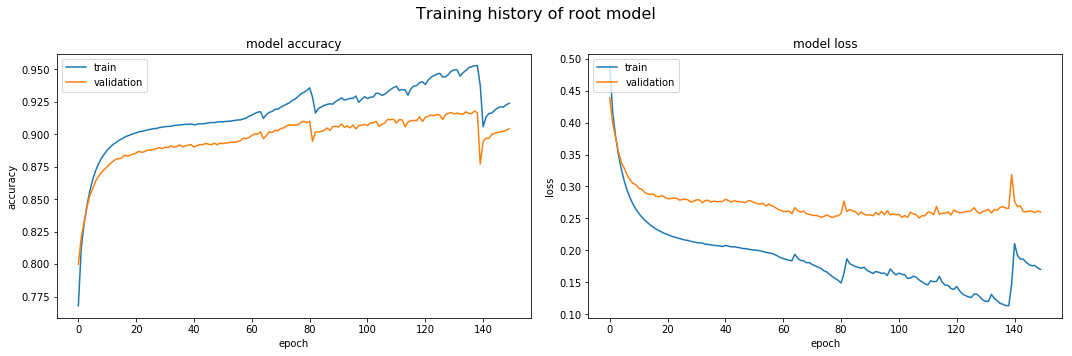

In [13]:
# Visualize model learning
plt.clf()

plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
# plt.show()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.tight_layout()
plt.suptitle("Training history of root model", fontsize=16)
plt.subplots_adjust(top=0.85)
plt.show()

In [14]:
# Load best performance model
best_model = load_model("Pitch_depth3.h5")

In [16]:
# Evaluate predictions in terms of labels

# Predict chords from each test sample melody
Y_pitches_pred = best_model.predict([X_melody_test, X_pitches_test])

# Compute accuracy and kappa score
print("Categorical accuracy of combined chord label prediction: {0:.4f}".format(harmoutil.compute_multiclass_binary_accuracy_score(Y_pitches_test, Y_pitches_pred)))
print("Kappa score of combined chord label prediction: {0:.4f}".format(harmoutil.compute_multiclass_binary_kappa_score(Y_pitches_test, Y_pitches_pred)))

Categorical accuracy of combined chord label prediction: 0.9175
TP: 109696 TN: 251096 FP: 13796 FN: 18664
Kappa score of combined chord label prediction: 0.8104
